In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [2]:
train_vanilla = False

In [3]:
device = get_device(1)

In [4]:
device

device(type='cuda', index=1)

In [5]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

Playable HPs :
- LoRA rank
- trade-off

Other HPs :
- batch_size

In [6]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 1000
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [7]:
random_seed = 88

## Get MNIST loaders

In [8]:
# We train on MNIST 0 to 4, then each new task is being able to classify a new digit (5 to 9)

In [9]:
train_loaders_list, val_loaders_list, test_loaders_list = get_MNIST_loaders(data_path, batch_size, random_seed, 0.8)

## Train vanilla ANN on digits 0 to 4

In [10]:
if train_vanilla :
    train_loader = train_loaders_list[1]
    test_loader = test_loaders_list[1]

In [11]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 5

In [12]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs, random_seed)

In [13]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


In [14]:
if train_vanilla :
    print(test(model, test_loader, batch_size, device))

100.0


## Save vanilla ANN

In [15]:
if train_vanilla :
    vanilla_path = model_path+"ICL1_state_dict_digit_0.pth"

In [16]:
if train_vanilla :
    save(vanilla_path, model)

## CL on digits 1 to 9 with LoRA

In [17]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 40)
    alpha = trial.suggest_float("alpha", 0.5, 3)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 1e-5, 5e-4)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    train_loader = train_loaders_list[task_number+1]
    #val_loader = val_loaders[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [19]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed).to(device)

    # Train
    train_loader = train_loaders_list[i+1]
    #val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL1_state_dict_digit_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [20]:
def call_greedy_HPO(n_trials) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL1_state_dict_digit_0.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digit 0
    test_accs = np.zeros(10)
    test_acc = test(lora_ann_model, test_loaders_list[1], batch_size, device)
    test_accs[0] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    best_params = []
    scores = [test_acc]
    test_accs_matrix = [test_accs]
    mean_test_accs_through_past_tasks = [test_acc]

    for i in range(1,10) :
        print(f"Learning Task {i+1}")
        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name="The Search",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        params = num_inputs, num_hidden, num_outputs, batch_size
        partial_objective = partial(objective, i, model_path, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials,
                    timeout=3600)

        # Retrain and save a model with the best params
        best_trial = study.best_trial
        best_params.append(best_trial.params)
        test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
        
        model_path = path + f"ICL1_state_dict_digit_{i}.pth"
        
        # Compute and store scores
        mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
        score = mu - sigma
        
        scores.append(score)
        test_accs_matrix.append(test_accs)
        mean_test_accs_through_past_tasks.append(mu)
    
    return test_accs_matrix

In [21]:
n_trials_list = [4,8,16,32,64]

In [22]:
test_accs_matrix_list = []
for n_trials in n_trials_list :
    test_accs_matrix = call_greedy_HPO(n_trials)
    test_accs_matrix_list += [test_accs_matrix]

[I 2024-05-27 16:05:38,329] A new study created in memory with name: The Search


Learning Task 2


100%|██████████| 4/4 [00:02<00:00,  1.85it/s]
[I 2024-05-27 16:05:40,682] Trial 0 finished with value: 98.44 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
[I 2024-05-27 16:05:41,440] Trial 1 finished with value: 98.10428571428574 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.86it/s]
[I 2024-05-27 16:05:42,167] Trial 2 finished with value: 95.64857142857144 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 4/4 [00:02<00:00,  1.86it/s]
[I 2024-05-27 16:05:44,506] Trial 3 finished with value: 97.76999999999998 and parameters: {'lora_rank': 10, 'alpha': 2.6255006696373164, 'lr': 0.00024795431885858184,

Learning Task 3


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-27 16:05:49,714] Trial 0 finished with value: -12.177828933251583 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -12.177828933251583.
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-27 16:05:50,472] Trial 1 finished with value: -10.44440518642812 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -10.44440518642812.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-27 16:05:51,230] Trial 2 finished with value: 31.57857697907863 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: 31.57857697907863.
100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
[I 2024-05-27 16:05:53,415] Trial 3 finished with value: -0.42117360547686644 and parameters: {'lora_rank': 10, '

Learning Task 4


100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
[I 2024-05-27 16:05:57,100] Trial 0 finished with value: -15.303859059201315 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -15.303859059201315.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:05:57,955] Trial 1 finished with value: -16.20392045617898 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -15.303859059201315.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:05:58,807] Trial 2 finished with value: 11.311764532127292 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: 11.311764532127292.
100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
[I 2024-05-27 16:06:01,134] Trial 3 finished with value: -13.329787617385453 and parameters: {'lora_rank': 10,

Learning Task 5


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:06:04,804] Trial 0 finished with value: -19.70928673714142 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.70928673714142.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:06:05,723] Trial 1 finished with value: -19.87475307001952 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -19.70928673714142.
100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
[I 2024-05-27 16:06:06,644] Trial 2 finished with value: -12.637588127088865 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -12.637588127088865.
100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:06:08,944] Trial 3 finished with value: -13.659526209958322 and parameters: {'lora_rank': 10, 

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.35it/s]
[I 2024-05-27 16:06:12,509] Trial 0 finished with value: -20.520702518780638 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.520702518780638.
100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
[I 2024-05-27 16:06:13,453] Trial 1 finished with value: -20.574278350357883 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -20.520702518780638.
100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
[I 2024-05-27 16:06:14,401] Trial 2 finished with value: -15.268734717534844 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -15.268734717534844.
100%|██████████| 4/4 [00:01<00:00,  2.39it/s]
[I 2024-05-27 16:06:16,602] Trial 3 finished with value: -20.281480183426176 and parameters: {'lora_rank': 

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:06:20,306] Trial 0 finished with value: -20.684600436387754 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.684600436387754.
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[I 2024-05-27 16:06:21,366] Trial 1 finished with value: -20.684600436387754 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -20.684600436387754.
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
[I 2024-05-27 16:06:22,426] Trial 2 finished with value: -20.027835430957595 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -20.027835430957595.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:06:24,825] Trial 3 finished with value: -20.434995650155805 and parameters: {'lora_rank': 

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:06:28,811] Trial 0 finished with value: -19.568904905233495 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.568904905233495.
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
[I 2024-05-27 16:06:30,002] Trial 1 finished with value: -19.31934482643323 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -19.31934482643323.
100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
[I 2024-05-27 16:06:31,195] Trial 2 finished with value: -15.447926369033436 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -15.447926369033436.
100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:06:33,842] Trial 3 finished with value: -17.22757406157556 and parameters: {'lora_rank': 10,

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:06:37,817] Trial 0 finished with value: -20.178217610521667 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.178217610521667.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:06:39,052] Trial 1 finished with value: -20.190636058629323 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -20.178217610521667.
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[I 2024-05-27 16:06:40,289] Trial 2 finished with value: -16.02099465033599 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -16.02099465033599.
100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:06:42,886] Trial 3 finished with value: -20.045020988344547 and parameters: {'lora_rank': 10

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
[I 2024-05-27 16:06:46,948] Trial 0 finished with value: -19.955594183504914 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.955594183504914.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:06:48,277] Trial 1 finished with value: -19.926174430982805 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -19.926174430982805.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:06:49,633] Trial 2 finished with value: -18.926402325571015 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -18.926402325571015.
100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
[I 2024-05-27 16:06:52,413] Trial 3 finished with value: -19.793331284824426 and parameters: {'lora_rank': 

Learning Task 2


100%|██████████| 4/4 [00:02<00:00,  1.88it/s]
[I 2024-05-27 16:06:56,163] Trial 0 finished with value: 98.44 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-27 16:06:56,876] Trial 1 finished with value: 98.10428571428574 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
[I 2024-05-27 16:06:57,581] Trial 2 finished with value: 95.64857142857144 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
[I 2024-05-27 16:06:59,848] Trial 3 finished with value: 97.76999999999998 and parameters: {'lora_rank': 10, 'alpha': 2.6255006696373164, 'lr': 0.00024795431885858184,

Learning Task 3


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:07:10,931] Trial 0 finished with value: -10.078166737155932 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -10.078166737155932.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:07:11,677] Trial 1 finished with value: -8.278188523236636 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -8.278188523236636.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:07:12,422] Trial 2 finished with value: 11.610018910453647 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: 11.610018910453647.
100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:07:14,548] Trial 3 finished with value: 1.2067720240422517 and parameters: {'lora_rank': 10, '

Learning Task 4


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]
[I 2024-05-27 16:07:25,261] Trial 0 finished with value: -11.377099528106484 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -11.377099528106484.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-27 16:07:26,102] Trial 1 finished with value: -14.10979601695847 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -11.377099528106484.
100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
[I 2024-05-27 16:07:26,942] Trial 2 finished with value: -5.272401245541182 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -5.272401245541182.
100%|██████████| 4/4 [00:01<00:00,  2.13it/s]
[I 2024-05-27 16:07:29,182] Trial 3 finished with value: -7.642672295084921 and parameters: {'lora_rank': 10, 

Learning Task 5


100%|██████████| 4/4 [00:01<00:00,  2.25it/s]
[I 2024-05-27 16:07:40,360] Trial 0 finished with value: -17.355321949673872 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -17.355321949673872.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:07:41,255] Trial 1 finished with value: -17.893783429074734 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -17.355321949673872.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:07:42,151] Trial 2 finished with value: -11.399638152385279 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -11.399638152385279.
100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
[I 2024-05-27 16:07:44,428] Trial 3 finished with value: -8.10244927055701 and parameters: {'lora_rank': 10

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]
[I 2024-05-27 16:07:55,527] Trial 0 finished with value: -20.36104420612104 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.36104420612104.
100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
[I 2024-05-27 16:07:56,478] Trial 1 finished with value: -20.124240513008655 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -20.124240513008655.
100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
[I 2024-05-27 16:07:57,422] Trial 2 finished with value: -15.647123113130707 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -15.647123113130707.
100%|██████████| 4/4 [00:01<00:00,  2.38it/s]
[I 2024-05-27 16:07:59,625] Trial 3 finished with value: -19.286913333172574 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:08:10,974] Trial 0 finished with value: -19.63533412144583 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.63533412144583.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-27 16:08:12,042] Trial 1 finished with value: -20.03166595557463 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -19.63533412144583.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:08:13,110] Trial 2 finished with value: -17.36782691639331 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.36782691639331.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:08:15,552] Trial 3 finished with value: -18.894122319874015 and parameters: {'lora_rank': 10, 'a

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
[I 2024-05-27 16:08:28,029] Trial 0 finished with value: -19.066664947385824 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.066664947385824.
100%|██████████| 1/1 [00:00<00:00,  1.98it/s]
[I 2024-05-27 16:08:29,235] Trial 1 finished with value: -18.595998095285868 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -18.595998095285868.
100%|██████████| 1/1 [00:00<00:00,  2.02it/s]
[I 2024-05-27 16:08:30,434] Trial 2 finished with value: -16.67191140504195 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -16.67191140504195.
100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
[I 2024-05-27 16:08:33,125] Trial 3 finished with value: -15.169493361346717 and parameters: {'lora_rank': 10

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:08:46,413] Trial 0 finished with value: -18.326024800390293 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -18.326024800390293.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:08:47,653] Trial 1 finished with value: -19.349752195978475 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -18.326024800390293.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:08:48,892] Trial 2 finished with value: -17.586898453630297 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.586898453630297.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:08:51,515] Trial 3 finished with value: -17.69869491092986 and parameters: {'lora_rank': 1

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-27 16:09:04,706] Trial 0 finished with value: -17.93493470484178 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -17.93493470484178.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-27 16:09:06,048] Trial 1 finished with value: -18.151195714970008 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -17.93493470484178.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-27 16:09:07,392] Trial 2 finished with value: -17.231532535430762 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.231532535430762.
100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-27 16:09:10,140] Trial 3 finished with value: -17.186452947633434 and parameters: {'lora_rank': 10,

Learning Task 2


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]
[I 2024-05-27 16:09:23,527] Trial 0 finished with value: 98.44 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
[I 2024-05-27 16:09:24,246] Trial 1 finished with value: 98.10428571428574 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.87it/s]
[I 2024-05-27 16:09:24,967] Trial 2 finished with value: 95.64857142857144 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 4/4 [00:02<00:00,  1.87it/s]
[I 2024-05-27 16:09:27,299] Trial 3 finished with value: 97.76999999999998 and parameters: {'lora_rank': 10, 'alpha': 2.6255006696373164, 'lr': 0.00024795431885858184,

Learning Task 3


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:09:49,446] Trial 0 finished with value: -11.820815907470376 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -11.820815907470376.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:09:50,186] Trial 1 finished with value: -7.277806957464755 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -7.277806957464755.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:09:50,930] Trial 2 finished with value: 12.6255137279419 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: 12.6255137279419.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:09:53,050] Trial 3 finished with value: 1.4297254028720445 and parameters: {'lora_rank': 10, 'alph

Learning Task 4


100%|██████████| 4/4 [00:01<00:00,  2.13it/s]
[I 2024-05-27 16:10:13,930] Trial 0 finished with value: -13.493488519834951 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -13.493488519834951.
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-27 16:10:14,769] Trial 1 finished with value: -15.178847776924865 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -13.493488519834951.
100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-27 16:10:15,606] Trial 2 finished with value: -8.138442917406124 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -8.138442917406124.
100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-27 16:10:17,856] Trial 3 finished with value: -10.556987406075617 and parameters: {'lora_rank': 10

Learning Task 5


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:10:42,819] Trial 0 finished with value: -18.761648974385714 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -18.761648974385714.
100%|██████████| 1/1 [00:00<00:00,  2.26it/s]
[I 2024-05-27 16:10:43,711] Trial 1 finished with value: -19.372888129003254 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -18.761648974385714.
100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
[I 2024-05-27 16:10:44,605] Trial 2 finished with value: -14.804251050007995 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -14.804251050007995.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:10:46,839] Trial 3 finished with value: -11.349228726846349 and parameters: {'lora_rank': 

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.45it/s]
[I 2024-05-27 16:11:11,843] Trial 0 finished with value: -20.547468194008122 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.547468194008122.
100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
[I 2024-05-27 16:11:12,772] Trial 1 finished with value: -20.045561890881302 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -20.045561890881302.
100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
[I 2024-05-27 16:11:13,719] Trial 2 finished with value: -16.316880986370403 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -16.316880986370403.
100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:11:15,890] Trial 3 finished with value: -19.612510968790648 and parameters: {'lora_rank': 

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:11:39,848] Trial 0 finished with value: -20.009010360890052 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.009010360890052.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:11:40,910] Trial 1 finished with value: -19.94736008324103 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -19.94736008324103.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:11:41,963] Trial 2 finished with value: -18.209200414720982 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -18.209200414720982.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:11:44,360] Trial 3 finished with value: -19.63041789302068 and parameters: {'lora_rank': 10,

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
[I 2024-05-27 16:12:10,933] Trial 0 finished with value: -19.796664417588815 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.796664417588815.
100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
[I 2024-05-27 16:12:12,121] Trial 1 finished with value: -19.100174776631487 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -19.100174776631487.
100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
[I 2024-05-27 16:12:13,307] Trial 2 finished with value: -15.574925711338807 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -15.574925711338807.
100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
[I 2024-05-27 16:12:16,004] Trial 3 finished with value: -13.191651054836726 and parameters: {'lora_rank': 

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:12:45,162] Trial 0 finished with value: -19.070295367591854 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.070295367591854.
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[I 2024-05-27 16:12:46,404] Trial 1 finished with value: -19.721432023659368 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -19.070295367591854.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:12:47,642] Trial 2 finished with value: -17.55708139821578 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.55708139821578.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:12:50,213] Trial 3 finished with value: -18.22154070170581 and parameters: {'lora_rank': 10,

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:13:18,972] Trial 0 finished with value: -18.58857749565646 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -18.58857749565646.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:13:20,308] Trial 1 finished with value: -18.775258726215952 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -18.58857749565646.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-27 16:13:21,650] Trial 2 finished with value: -17.3281620992828 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.3281620992828.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:13:24,357] Trial 3 finished with value: -18.0867860522934 and parameters: {'lora_rank': 10, 'alph

Learning Task 2


100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-27 16:13:54,254] Trial 0 finished with value: 98.44 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
[I 2024-05-27 16:13:54,963] Trial 1 finished with value: 98.10428571428574 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.88it/s]
[I 2024-05-27 16:13:55,679] Trial 2 finished with value: 95.64857142857144 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
[I 2024-05-27 16:13:57,956] Trial 3 finished with value: 97.76999999999998 and parameters: {'lora_rank': 10, 'alpha': 2.6255006696373164, 'lr': 0.00024795431885858184,

Learning Task 3


100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
[I 2024-05-27 16:14:41,486] Trial 0 finished with value: -9.11348437423937 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -9.11348437423937.
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[I 2024-05-27 16:14:42,228] Trial 1 finished with value: -6.293216513898777 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -6.293216513898777.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:14:42,969] Trial 2 finished with value: 9.801583215129703 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: 9.801583215129703.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:14:45,093] Trial 3 finished with value: 4.997534221055645 and parameters: {'lora_rank': 10, 'alpha':

Learning Task 4


100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-27 16:15:25,080] Trial 0 finished with value: -13.228305314560338 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -13.228305314560338.
100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
[I 2024-05-27 16:15:25,925] Trial 1 finished with value: -15.748006084664112 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -13.228305314560338.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-27 16:15:26,769] Trial 2 finished with value: -6.515763445697445 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -6.515763445697445.
100%|██████████| 4/4 [00:01<00:00,  2.12it/s]
[I 2024-05-27 16:15:29,024] Trial 3 finished with value: -9.780155316123487 and parameters: {'lora_rank': 10,

Learning Task 5


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:16:24,422] Trial 0 finished with value: -18.912431398037874 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -18.912431398037874.
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[I 2024-05-27 16:16:25,330] Trial 1 finished with value: -19.313944674545514 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -18.912431398037874.
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[I 2024-05-27 16:16:26,237] Trial 2 finished with value: -10.76716234479791 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -10.76716234479791.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:16:28,491] Trial 3 finished with value: -9.368470922858869 and parameters: {'lora_rank': 10,

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:17:23,492] Trial 0 finished with value: -20.547468194008122 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.547468194008122.
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
[I 2024-05-27 16:17:24,430] Trial 1 finished with value: -20.202322532612765 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -20.202322532612765.
100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
[I 2024-05-27 16:17:25,376] Trial 2 finished with value: -16.747346432118096 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -16.747346432118096.
100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:17:27,552] Trial 3 finished with value: -19.6395665496898 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:18:16,984] Trial 0 finished with value: -19.94562399394863 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.94562399394863.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:18:18,035] Trial 1 finished with value: -19.989291909869408 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -19.94562399394863.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:18:19,090] Trial 2 finished with value: -17.40511209417106 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.40511209417106.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:18:21,505] Trial 3 finished with value: -18.327647568230883 and parameters: {'lora_rank': 10, '

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
[I 2024-05-27 16:19:18,630] Trial 0 finished with value: -19.16249243561232 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.16249243561232.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:19:19,817] Trial 1 finished with value: -18.16853171453942 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -18.16853171453942.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:19:21,010] Trial 2 finished with value: -16.014417586970943 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -16.014417586970943.
100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-27 16:19:23,646] Trial 3 finished with value: -12.74109782083855 and parameters: {'lora_rank': 10, '

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-27 16:20:27,341] Trial 0 finished with value: -19.194122865438082 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.194122865438082.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:20:28,583] Trial 1 finished with value: -19.33560787913939 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -19.194122865438082.
100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
[I 2024-05-27 16:20:29,829] Trial 2 finished with value: -17.21718012339494 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.21718012339494.
100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:20:32,411] Trial 3 finished with value: -17.904896610428686 and parameters: {'lora_rank': 10,

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:21:30,577] Trial 0 finished with value: -18.960766887949674 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -18.960766887949674.
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
[I 2024-05-27 16:21:31,913] Trial 1 finished with value: -18.88861212377126 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -18.88861212377126.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:21:33,245] Trial 2 finished with value: -17.122694065069552 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.122694065069552.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:21:35,955] Trial 3 finished with value: -18.062841473959956 and parameters: {'lora_rank': 10

Learning Task 2


100%|██████████| 4/4 [00:02<00:00,  1.87it/s]
[I 2024-05-27 16:22:33,481] Trial 0 finished with value: 98.44 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-27 16:22:34,192] Trial 1 finished with value: 98.10428571428574 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 1/1 [00:00<00:00,  1.92it/s]
[I 2024-05-27 16:22:34,898] Trial 2 finished with value: 95.64857142857144 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 0 with value: 98.44.
100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
[I 2024-05-27 16:22:37,167] Trial 3 finished with value: 97.76999999999998 and parameters: {'lora_rank': 10, 'alpha': 2.6255006696373164, 'lr': 0.00024795431885858184,

Learning Task 3


100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:23:58,653] Trial 0 finished with value: -9.11348437423937 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -9.11348437423937.
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[I 2024-05-27 16:23:59,390] Trial 1 finished with value: -6.293216513898777 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -6.293216513898777.
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]
[I 2024-05-27 16:24:00,130] Trial 2 finished with value: 9.801583215129703 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: 9.801583215129703.
100%|██████████| 4/4 [00:01<00:00,  2.18it/s]
[I 2024-05-27 16:24:02,251] Trial 3 finished with value: 4.997534221055645 and parameters: {'lora_rank': 10, 'alpha':

Learning Task 4


100%|██████████| 4/4 [00:01<00:00,  2.11it/s]
[I 2024-05-27 16:25:21,177] Trial 0 finished with value: -13.228305314560338 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -13.228305314560338.
100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-27 16:25:22,017] Trial 1 finished with value: -15.748006084664112 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -13.228305314560338.
100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-27 16:25:22,853] Trial 2 finished with value: -6.515763445697445 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -6.515763445697445.
100%|██████████| 4/4 [00:01<00:00,  2.13it/s]
[I 2024-05-27 16:25:25,095] Trial 3 finished with value: -9.780155316123487 and parameters: {'lora_rank': 10,

Learning Task 5


100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
[I 2024-05-27 16:27:25,489] Trial 0 finished with value: -18.912431398037874 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -18.912431398037874.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-27 16:27:26,408] Trial 1 finished with value: -19.313944674545514 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -18.912431398037874.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-27 16:27:27,325] Trial 2 finished with value: -10.76716234479791 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -10.76716234479791.
100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
[I 2024-05-27 16:27:29,628] Trial 3 finished with value: -9.368470922858869 and parameters: {'lora_rank': 10,

Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.43it/s]
[I 2024-05-27 16:29:13,226] Trial 0 finished with value: -20.547468194008122 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -20.547468194008122.
100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
[I 2024-05-27 16:29:14,196] Trial 1 finished with value: -20.202322532612765 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -20.202322532612765.
100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
[I 2024-05-27 16:29:15,157] Trial 2 finished with value: -16.747346432118096 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -16.747346432118096.
100%|██████████| 4/4 [00:01<00:00,  2.42it/s]
[I 2024-05-27 16:29:17,330] Trial 3 finished with value: -19.6395665496898 and parameters: {'lora_rank': 10

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.23it/s]
[I 2024-05-27 16:30:52,257] Trial 0 finished with value: -19.94562399394863 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.94562399394863.
100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
[I 2024-05-27 16:30:53,335] Trial 1 finished with value: -19.989291909869408 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -19.94562399394863.
100%|██████████| 1/1 [00:00<00:00,  2.24it/s]
[I 2024-05-27 16:30:54,387] Trial 2 finished with value: -17.40511209417106 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.40511209417106.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:30:56,786] Trial 3 finished with value: -18.327647568230883 and parameters: {'lora_rank': 10, '

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-27 16:32:39,656] Trial 0 finished with value: -19.16249243561232 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.16249243561232.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:32:40,847] Trial 1 finished with value: -18.16853171453942 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -18.16853171453942.
100%|██████████| 1/1 [00:00<00:00,  2.06it/s]
[I 2024-05-27 16:32:42,034] Trial 2 finished with value: -16.014417586970943 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -16.014417586970943.
100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
[I 2024-05-27 16:32:44,668] Trial 3 finished with value: -12.74109782083855 and parameters: {'lora_rank': 10, '

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:34:36,670] Trial 0 finished with value: -19.436540489617023 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.436540489617023.
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
[I 2024-05-27 16:34:37,904] Trial 1 finished with value: -19.481027931462865 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 0 with value: -19.436540489617023.
100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
[I 2024-05-27 16:34:39,132] Trial 2 finished with value: -17.31058222183334 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.31058222183334.
100%|██████████| 4/4 [00:01<00:00,  2.24it/s]
[I 2024-05-27 16:34:41,706] Trial 3 finished with value: -18.31073642337338 and parameters: {'lora_rank': 10,

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]
[I 2024-05-27 16:36:52,475] Trial 0 finished with value: -19.263262416694616 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0002688872762745973, 'num_epochs': 4}. Best is trial 0 with value: -19.263262416694616.
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]
[I 2024-05-27 16:36:53,802] Trial 1 finished with value: -18.92459715075583 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0003614958072247864, 'num_epochs': 1}. Best is trial 1 with value: -18.92459715075583.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-27 16:36:55,139] Trial 2 finished with value: -17.184545821307434 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.00046508183145389554, 'num_epochs': 1}. Best is trial 2 with value: -17.184545821307434.
100%|██████████| 4/4 [00:01<00:00,  2.16it/s]
[I 2024-05-27 16:36:57,859] Trial 3 finished with value: -18.40187929674272 and parameters: {'lora_rank': 10,

In [23]:
def visualize_greedy_HPO_matrix(test_accs_matrix, n_trials, savefig=False):
    plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
    plt.yticks(np.arange(10), np.arange(0, 10))
    plt.xlabel("Accuracy on digit j...")
    plt.ylabel("...after training on digit i")
    plt.title(f"Result of greedy HPO with {n_trials} trials per task")
    plt.colorbar()
    if savefig :
        plt.savefig(f"results/ICL1_{n_trials}_trial_greedy_HPO_matrix_LoRA.png")
    plt.show()

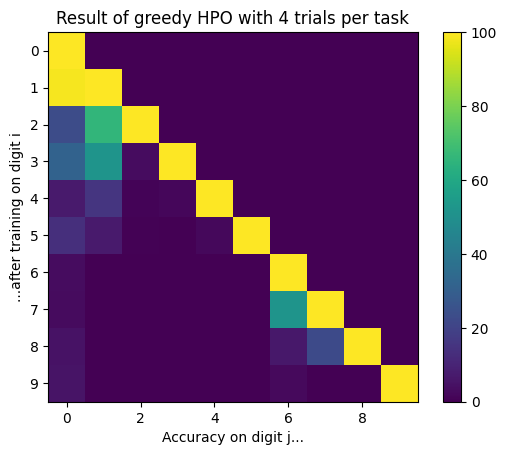

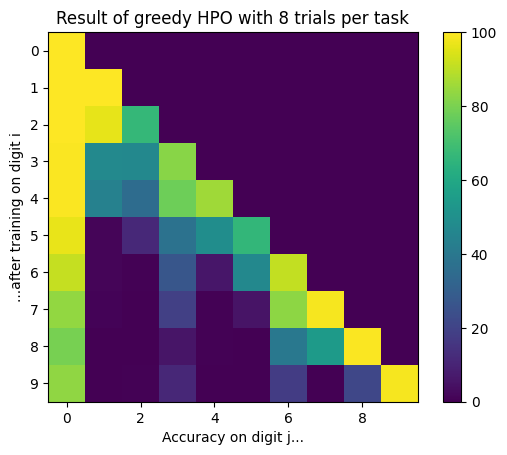

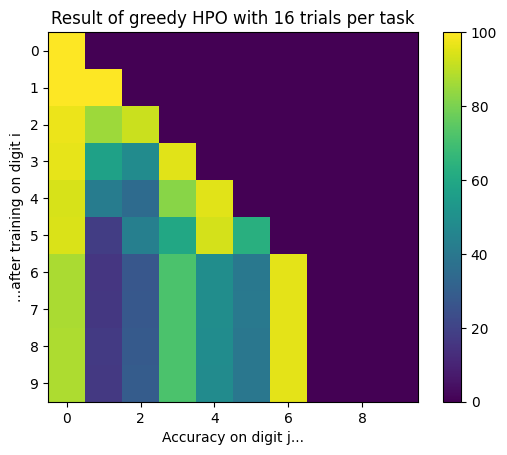

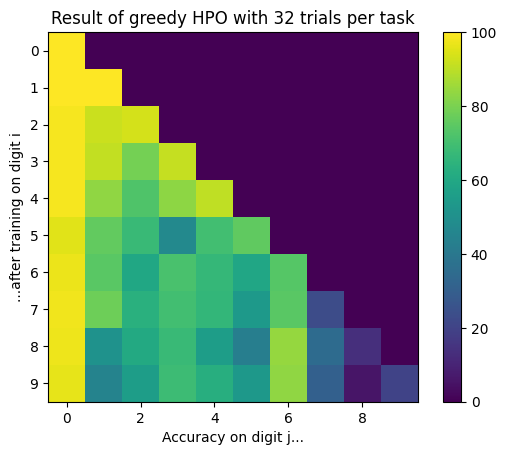

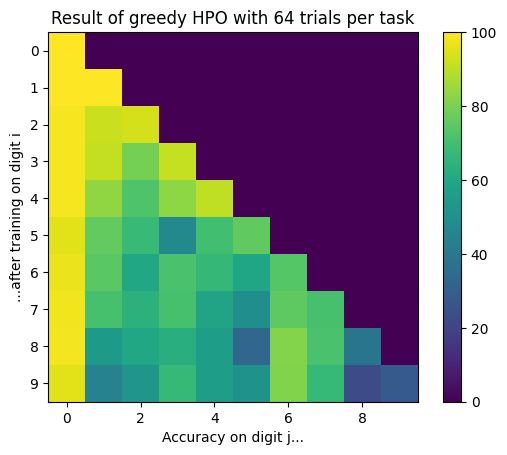

In [24]:
for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list) :
    visualize_greedy_HPO_matrix(test_accs_matrix, n_trials, savefig=True)

In [25]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [26]:
def visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=False):
    # Normalize n_trials values for the colormap
    norm = mcolors.LogNorm(vmin=min(n_trials_list), vmax=max(n_trials_list))
    colormap = cm.viridis

    fig, ax = plt.subplots(figsize=(10, 6))
    for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list):
        mean_accs = np.array(test_accs_matrix).sum(1) / np.arange(1, 11, 1)
        color = colormap(norm(n_trials))
        ax.plot(range(0,10), mean_accs, label=f"{n_trials} trials", color=color)
    
    ax.set_xlabel("Digits trained")
    ax.set_ylabel("Average accuracy for classes trained so far")
    ax.set_ylim(0, 100)
    ax.set_title("Result of greedy HPO with various numbers of trials")

    # Create a scalar mappable for the color bar
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Number of Trials')

    ax.legend(loc='lower left')
    
    if savefig:
        plt.savefig(f"results/ICL1_greedy_HPO_curve_LoRA.png")
    
    plt.show()

# Example usage
# visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=True)


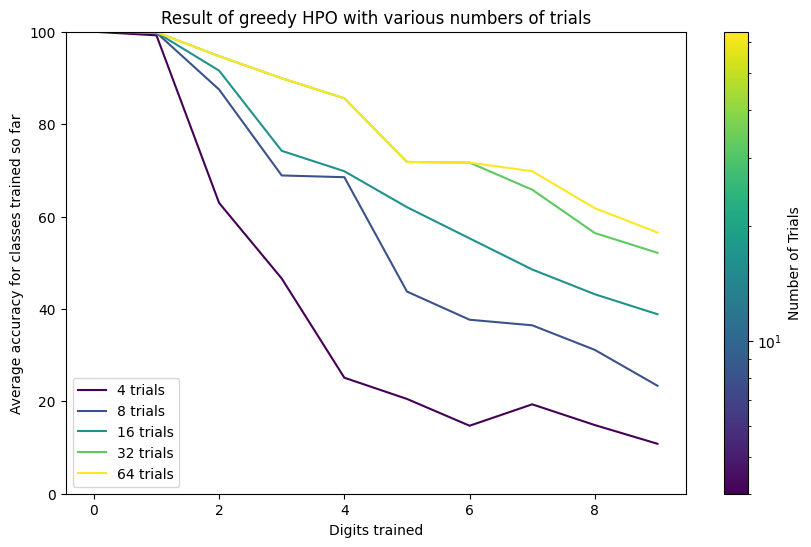

In [27]:
visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=True)